# Kuramoto–Sivashinsky 

This notebook aims to apply the OpInf method [3] (Non-intrusive Model Reduction via Operator Inference) to the _Kuramoto–Sivashinsky (KS)_ Partial Differential Equation (PDE) used to model diffuse-thermal instabilities in a laminar flame front. It has the following form:

<center>$u_t = -v \cdot u_{xxxx}- u_{xx}-u \cdot u_{x}$</center>

and for the problem analyzed in this project, we considered $v=1$ and the following initial and boundary conditions:

$u(x,0)= (\cos{\frac{2\pi x}{L}})\cdot (1+\sin{\frac{2\pi x}{L}} ) ,\space ∀x \space$ and $t=0$.

$u(0,t)=u(L,t),\space ∀t$ and $x=0$.

with $x \in [0,L]$ and $ t \in [0,6\times 10^4] $.

We used a grid of $512$ nodes in $x$ and $ 48 \times 10^4$ in $t$ for $L=200$.

This configuration follows the pattern indicated in the study article [1] in item 5.3. It was necessary to reduce the temporal variation to $0.125$ to work better with the LSODA integrator [4] used at the end of the process.

To make the analytical solution, we adapted a specific notebook [2] mentioned in the study article [1].

For the use of OpInf we used the SimulAI library [5].

## References

[1] Vlachas, Pantelis R., et al. "Backpropagation algorithms and reservoir computing in recurrent neural networks for the forecasting of complex spatiotemporal dynamics." Neural Networks 126 (2020): 191-217.


[2] Vlachas, Pantelis R., GitHub Pessoal, Disponível em: https://github.com/pvlachas/RNN-RC-Chaos/blob/master/Data/KuramotoSivashinskyGP512/Utils/KS.py. Accessed: 13 Apr. 2023.

[3] Qian, E., Farcas, I.-G., Willcox, K. Reduced operator inference for nonlinear partial differential equations, arXiv:2102.00083v1, 29 Jan 2021.

[4] LSODA, Ordinary Differential Equation Solver for Stiff or Non-Stiff System. (Sep 2005). Bibliographic information available from INIS: http://inis.iaea.org/search/search.aspx?orig_q=RN:41086668 

[5] IBM. SimulAI Toolkit: A Python Package with Data-Driven Pipelines for 
Physics-Informed Machine Learning. 2022, doi:10.5281/zenodo.7351516.

## Authors

*  Nicole Pan Tavares (nicoleptav@gmail.com)
*  Wilson Bagni Junior (www.ic.unicamp.br/~wbagni)

# Imports

In [ ]:
# This code is designed to be used in the Google 
# Colaboratory environment (https://colab.research.google.com/). Adjustments may 
# be made to run it in other environments 

# Installing the SimulAI tool

!pip install simulai-toolkit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.0/214.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 73.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import warnings

import time

from simulai.metrics import L2Norm
import time
with warnings.catch_warnings():
    
    from scipy.integrate import odeint
    import matplotlib.pyplot as plt
    import numpy as np

    from numpy import pi
    from scipy.fftpack import fft, ifft
    from simulai.regression import OpInf
    from simulai.math.integration import RK4, LSODA, FunctionWrapper, ClassWrapper
    from simulai.math.differentiation import CollocationDerivative
    from simulai.rom import POD
    from simulai.io import Reshaper
    from simulai.simulation import Pipeline
    


# Adjustment to numpy's error/warning handling for floating point operations

np.seterr(over='raise', invalid='raise')

/usr/local/lib/python3.10/dist-packages/simulai/regression/_opinf.py:33: UserWarning: Trying to import MPI in /usr/local/lib/python3.10/dist-packages/simulai/regression/_opinf.py.
  warnings.warn(f"Trying to import MPI in {__file__}.")
/usr/local/lib/python3.10/dist-packages/simulai/regression/_opinf.py:34: UserWarning: mpi4py is not installed. If you want to execute MPI jobs, we recommend you install it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/simulai/parallel.py:24: UserWarning: Trying to import MPI in /usr/local/lib/python3.10/dist-packages/simulai/parallel.py.
  warnings.warn(f"Trying to import MPI in {__file__}.")
/usr/local/lib/python3.10/dist-packages/simulai/parallel.py:25: UserWarning: mpi4py is not installed. If you want to execute MPI jobs, we recommend you install it.
  warnings.warn(


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [ ]:
# Function for normal plot

def plot(data):
  plt.figure(figsize=(4, 8))
  n, s = np.meshgrid(np.arange(np.shape(data)[0]), np.arange(np.shape(data)[1])+1)
  plt.contourf(s, n, np.transpose(data), 15, cmap=plt.get_cmap("seismic"))
  plt.colorbar()
  plt.show()
  plt.close()

In [ ]:
# Function to compare plots

def compare_plot(data1, data2, text1="Sample 1", text2="Sample 2"):

  if data1.shape != data2.shape:
    print("Both data must have the same shape")
    print("Data1:", data1.shape)
    print("Data2:", data2.shape)
  else:

    fig, axs = plt.subplots(1, 2, sharey=True,  figsize=(7, 8))
    fig.tight_layout(pad=2.0)
    n, s = np.meshgrid(np.arange(np.shape(data1)[0]), np.arange(np.shape(data1)[1])+1)
    im0 = axs[0].contourf(s, n, np.transpose(data1), 15, cmap=plt.get_cmap("seismic"))
    plt.colorbar(im0)
    axs[0].set_title(text1)

    im1 = axs[1].contourf(s, n, np.transpose(data2), 15, cmap=plt.get_cmap("seismic"))
    plt.colorbar(im1)
    axs[1].set_title(text2)

    for ax in axs.flat:
        ax.set(xlabel='x', ylabel='t')

    plt.show()
    plt.close()

In [ ]:
def RMSE(exact, approximated):
  n= exact.shape[0]* exact.shape[1]
  return np.sqrt(((exact -approximated)**2).sum()/n)

# Analytical Solution

In [ ]:
# This cell fully reproduces the KS class developed to solve
# the Kuramoto-Sivashinsky PDE.

class KS:
    #
    # Solution of the 1D Kuramoto-Sivashinsky equation
    #
    # u_t + u*u_x + u_xx + u_xxxx = 0,
    # with periodic BCs on x \in [0, L]: u(x+L,t) = u(x,t).
    #
    # The nature of the solution depends on the system size L and on the initial
    # condition u(x,0).  Energy enters the system at long wavelengths via u_xx
    # (an unstable diffusion term), cascades to short wavelengths due to the
    # nonlinearity u*u_x, and dissipates via diffusion with u_xxxx.
    #
    # Spatial  discretization: spectral (Fourier)
    # Temporal discretization: exponential time differencing fourth-order Runge-Kutta
    # see AK Kassam and LN Trefethen, SISC 2005


    def __init__(self, L=16, N=128, dt=0.125, nsteps=None, tend=150, iout=1):
        #
        # Initialize
        L  = float(L); dt = float(dt); tend = float(tend)
        if (nsteps is None):
            nsteps = int(tend/dt)
        else:
            nsteps = int(nsteps)
            # override tend
            tend = dt*nsteps
        #
        # save to self
        self.L      = L
        self.N      = N
        self.dx     = L/N
        self.dt     = dt
        self.nsteps = nsteps
        self.iout   = iout
        self.nout   = int(nsteps/iout)
        #
        # set initial condition
        self.IC()
        #
        # initialize simulation arrays
        self.setup_timeseries()
        #
        # precompute Fourier-related quantities
        self.setup_fourier()
        #
        # precompute ETDRK4 scalar quantities:
        self.setup_etdrk4()


    def setup_timeseries(self, nout=None):
        if (nout != None):
            self.nout = int(nout)
        # nout+1 so we store the IC as well
        self.vv = np.zeros([self.nout+1, self.N], dtype=np.complex64)
        self.tt = np.zeros(self.nout+1)
        #
        # store the IC in [0]
        self.vv[0,:] = self.v0
        self.tt[0]   = 0.


    def setup_fourier(self, coeffs=None):
        self.x  = self.L*np.r_[0:self.N]/self.N
        self.k  = (2*pi)*np.r_[0:self.N/2, 0, -self.N/2+1:0]/self.L # Wave numbers
        # Fourier multipliers for the linear term Lu
        if (coeffs is None):
            # normal-form equation
            self.l = self.k**2 - self.k**4
        else:
            # altered-coefficients 
            self.l = -      coeffs[0]*np.ones(self.k.shape) \
                     -      coeffs[1]*1j*self.k             \
                     + (1 + coeffs[2])  *self.k**2          \
                     +      coeffs[3]*1j*self.k**3          \
                     - (1 + coeffs[4])  *self.k**4


    def setup_etdrk4(self):
        self.E  = np.exp(self.dt*self.l)
        self.E2 = np.exp(self.dt*self.l/2.)
        self.M  = 16                                           # no. of points for complex means
        self.r  = np.exp(1j*pi*(np.r_[1:self.M+1]-0.5)/self.M) # roots of unity
        self.LR = self.dt*np.repeat(self.l[:,np.newaxis], self.M, axis=1) + np.repeat(self.r[np.newaxis,:], self.N, axis=0)
        self.Q  = self.dt*np.real(np.mean((np.exp(self.LR/2.) - 1.)/self.LR, 1))
        self.f1 = self.dt*np.real( np.mean( (-4. -    self.LR              + np.exp(self.LR)*( 4. - 3.*self.LR + self.LR**2) )/(self.LR**3) , 1) )
        self.f2 = self.dt*np.real( np.mean( ( 2. +    self.LR              + np.exp(self.LR)*(-2. +    self.LR             ) )/(self.LR**3) , 1) )
        self.f3 = self.dt*np.real( np.mean( (-4. - 3.*self.LR - self.LR**2 + np.exp(self.LR)*( 4. -    self.LR             ) )/(self.LR**3) , 1) )
        self.g  = -0.5j*self.k


    def IC(self, u0=None, v0=None, testing=False):
        #
        # Set initial condition, either provided by user or by "template"
        if (v0 is None):
            # IC provided in u0 or use template
            if (u0 is None):
                # set u0
                if testing:
                    # template from AK Kassam and LN Trefethen, SISC 2005
                    u0 = np.cos((2*pi)*self.x/self.L)*(1. + np.sin((2*pi)*self.x/self.L))
                else:
                    # random noise
                    u0 = (np.random.rand(self.N) -0.5)*0.01
            else:
                # check the input size
                if (np.size(u0,0) != self.N):
                    print('Error: wrong IC array size')
                    return -1
                else:
                    # if ok cast to np.array
                    u0 = np.array(u0)
            # in any case, set v0:
            v0 = fft(u0)
        else:
            # the initial condition is provided in v0
            # check the input size
            if (np.size(v0,0) != self.N):
                print('Error: wrong IC array size')
                return -1
            else:
                # if ok cast to np.array
                v0 = np.array(v0)
                # and transform to physical space
                u0 = ifft(v0)
        #
        # and save to self
        self.u0  = u0
        self.v0  = v0
        self.v   = v0
        self.t   = 0.
        self.stepnum = 0
        self.ioutnum = 0 # [0] is the initial condition
        

    def step(self):
        #
        # Computation is based on v = fft(u), so linear term is diagonal.
        # The time-discretization is done via ETDRK4
        # (exponential time differencing - 4th order Runge Kutta)
        #
        v = self.v;                           Nv = self.g*fft(np.real(ifft(v))**2)
        a = self.E2*v + self.Q*Nv;            Na = self.g*fft(np.real(ifft(a))**2)
        b = self.E2*v + self.Q*Na;            Nb = self.g*fft(np.real(ifft(b))**2)
        c = self.E2*a + self.Q*(2.*Nb - Nv);  Nc = self.g*fft(np.real(ifft(c))**2)
        #
        self.v = self.E*v + Nv*self.f1 + 2.*(Na + Nb)*self.f2 + Nc*self.f3
        self.stepnum += 1
        self.t       += self.dt


    def simulate(self, nsteps=None, iout=None, restart=False, correction=[]):
        #
        # If not provided explicitly, get internal values
        if (nsteps is None):
            nsteps = self.nsteps
        else:
            nsteps = int(nsteps)
            self.nsteps = nsteps
        if (iout is None):
            iout = self.iout
            nout = self.nout
        else:
            self.iout = iout
        if restart:
            # update nout in case nsteps or iout were changed
            nout      = int(nsteps/iout)
            self.nout = nout
            # reset simulation arrays with possibly updated size
            self.setup_timeseries(nout=self.nout)
        #
        # advance in time for nsteps steps
        if (correction==[]):
            for n in range(1,self.nsteps+1):
                try:
                    self.step()
                except FloatingPointError:
                    #
                    # something exploded
                    # cut time series to last saved solution and return
                    self.nout = self.ioutnum
                    self.vv.resize((self.nout+1,self.N)) # nout+1 because the IC is in [0]
                    self.tt.resize(self.nout+1)          # nout+1 because the IC is in [0]
                    return -1
                if ( (self.iout>0) and (n%self.iout==0) ):
                    self.ioutnum += 1
                    self.vv[self.ioutnum,:] = self.v
                    self.tt[self.ioutnum]   = self.t
        else:
            # lots of code duplication here, but should improve speed instead of having the 'if correction' at every time step
            for n in range(1,self.nsteps+1):
                try:
                    self.step()
                    self.v += correction
                except FloatingPointError:
                    #
                    # something exploded
                    # cut time series to last saved solution and return
                    self.nout = self.ioutnum
                    self.vv.resize((self.nout+1,self.N)) # nout+1 because the IC is in [0]
                    self.tt.resize(self.nout+1)          # nout+1 because the IC is in [0]
                    return -1
                if ( (self.iout>0) and (n%self.iout==0) ):
                    self.ioutnum += 1
                    self.vv[self.ioutnum,:] = self.v
                    self.tt[self.ioutnum]   = self.t


    def fou2real(self):
        #
        # Convert from spectral to physical space
        self.uu = np.real(ifft(self.vv))


    def compute_Ek(self):
        #
        # compute all forms of kinetic energy
        #
        # Kinetic energy as a function of wavenumber and time
        self.compute_Ek_kt()
        # Time-averaged energy spectrum as a function of wavenumber
        self.Ek_k = np.sum(self.Ek_kt, 0)/(self.ioutnum+1) # not self.nout because we might not be at the end; ioutnum+1 because the IC is in [0]
        # Total kinetic energy as a function of time
        self.Ek_t = np.sum(self.Ek_kt, 1)
		# Time-cumulative average as a function of wavenumber and time
        self.Ek_ktt = np.cumsum(self.Ek_kt, 0) / np.arange(1,self.ioutnum+2)[:,None] # not self.nout because we might not be at the end; ioutnum+1 because the IC is in [0] +1 more because we divide starting from 1, not zero
		# Time-cumulative average as a function of time
        self.Ek_tt = np.cumsum(self.Ek_t, 0) / np.arange(1,self.ioutnum+2)[:,None] # not self.nout because we might not be at the end; ioutnum+1 because the IC is in [0] +1 more because we divide starting from 1, not zero

    def compute_Ek_kt(self):
        try:
            self.Ek_kt = 1./2.*np.real( self.vv.conj()*self.vv / self.N ) * self.dx
        except FloatingPointError:
            #
            # probable overflow because the simulation exploded, try removing the last solution
            problem=True
            remove=1
            self.Ek_kt = np.zeros([self.nout+1, self.N]) + 1e-313
            while problem:
                try:
                    self.Ek_kt[0:self.nout+1-remove,:] = 1./2.*np.real( self.vv[0:self.nout+1-remove].conj()*self.vv[0:self.nout+1-remove] / self.N ) * self.dx
                    problem=False
                except FloatingPointError:
                    remove+=1
                    problem=True
        return self.Ek_kt


    def space_filter(self, k_cut=2):
        #
        # spatially filter the time series
        self.uu_filt  = np.zeros([self.nout+1, self.N])
        for n in range(self.nout+1):
            v_filt = np.copy(self.vv[n,:])    # copy vv[n,:] (otherwise python treats it as reference and overwrites vv on the next line)
            v_filt[np.abs(self.k)>=k_cut] = 0 # set to zero wavenumbers > k_cut
            self.uu_filt[n,:] = np.real(ifft(v_filt))
        #
        # compute u_resid
        self.uu_resid = self.uu - self.uu_filt


    def space_filter_int(self, k_cut=2, N_int=10):
        #
        # spatially filter the time series
        self.N_int        = N_int
        self.uu_filt      = np.zeros([self.nout+1, self.N])
        self.uu_filt_int  = np.zeros([self.nout+1, self.N_int])
        self.x_int        = self.L*np.r_[0:self.N_int]/self.N_int 
        for n in range(self.nout+1):
            v_filt = np.copy(self.vv[n,:])   # copy vv[n,:] (otherwise python treats it as reference and overwrites vv on the next line)
            v_filt[np.abs(self.k)>=k_cut] = 313e6
            v_filt_int = v_filt[v_filt != 313e6] * self.N_int/self.N
            self.uu_filt_int[n,:] = np.real(ifft(v_filt_int))
            v_filt[np.abs(self.k)>=k_cut] = 0
            self.uu_filt[n,:] = np.real(ifft(v_filt))
        #
        # compute u_resid
        self.uu_resid = self.uu - self.uu_filt

In [ ]:
# As the time domain varies from 0 to 6 x 10^4 and we have 48 x 10^4 samples 
# On the grid, we have a dt of 0.125

# Domain conditions

L    = 200
N    = 512
dt   = 0.125
tend = 60000 
dns  = KS(L=L, N=N, dt=dt, tend=tend)

In [ ]:
# Definition of the initial condition for t=0

dns.IC(testing=True)


In [ ]:
# Solve the PDE and separate the dataset

#------------------------------------------------------------------------------
# simulate initial transient
dns.simulate()
# convert to physical space
dns.fou2real()


# Split the data

u = dns.uu

print(u.shape)

# At this stage we have the dataset at u matrix, that has 480001 rows and 512 columns.

(480001, 512)


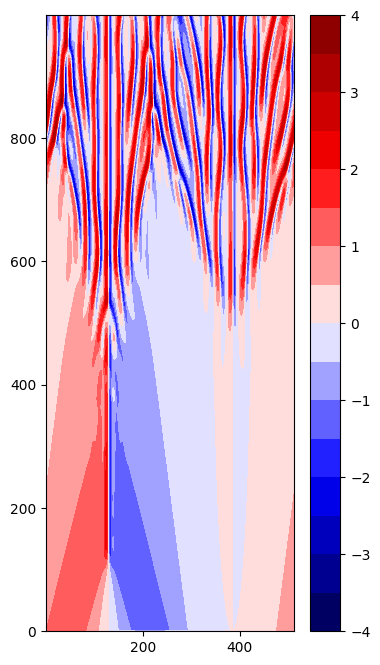

In [ ]:
# plotting the first 1000 samples

plot(u[0:1000,:])

# Data

Due the memory constraints we used a slice of the dataset. (150000 samples)


In [ ]:
t = np.arange(0.0, 60000.25, 0.125)

#Saving the original data so that, if necessary, to recover information

u_backup = u
t_backup = t


In [ ]:
# Taking 150000 samples

u = u_backup[10000:160000]
t = t_backup[10000:160000]

In [ ]:
print("u", u.shape)
print("t", t.shape)

u (150000, 512)
t (150000,)


# POD (Proper Orthogonal Decomposition)

We reduced the dimentions from $ 512 $ to $ 100$ using the method POD (Proper Orthogonal Decomposition).


In [ ]:
# Instantiating a Pipeline object in order to execute a reshaping and a POD projection in the data
n_components = 100

rom_config = {
               'n_components': n_components
              }
# Instantiating the class Pipeline
pipeline = Pipeline(stages=[('data_preparer', Reshaper()),
                            ('rom', POD(config=rom_config))])

# Executing the workflow shown in the list stages
pipeline.exec(input_data=u)

projected_data = pipeline.project_data(data=u)
reconstructed_data = pipeline.reconstruct_data(data=projected_data)


Executing a global pipeline.
Executed operation RESHAPER.
Relative contribution of the mean component: 0.0004033252480439842
Relative Modal Energy 0.9922794596207345
Executed operation POD.
Applying the global reconstruction strategy.


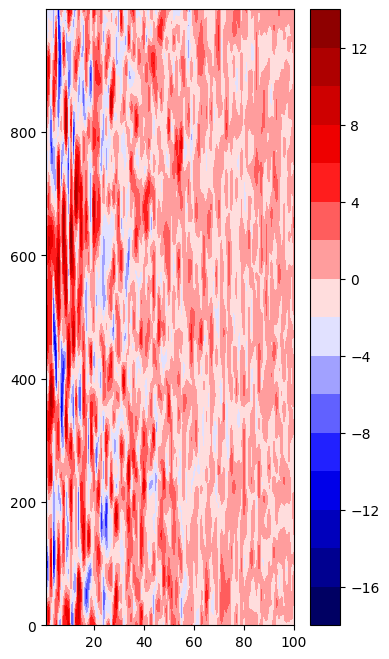

In [ ]:
plot(projected_data[0:1000])

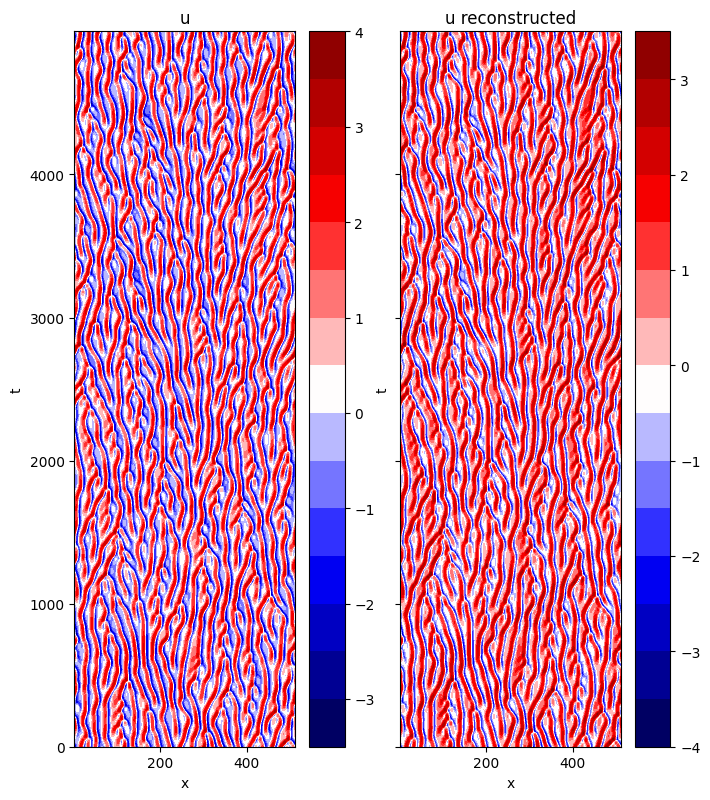

In [ ]:
# Comparing the reconstruction
compare_plot(u[0:5000], reconstructed_data[0:5000], "u", "u reconstructed")

# OpInf

As described in [3] OpInf is "a new scientific machine learning method that learns from data a computationally inexpensive surrogate model for predicting the evolution of a system governed by a time-dependent nonlinear partial differential equation (PDE), an enabling technology for many computational algorithms used in engineering settings".

Trying to obtain the best model, we executed a grid search for the best parameters. For this process, we splited the data between train ($90\%$) and test ($10\%$).

In [ ]:
# Let's define train and test dataset. 
# The train will be 90% of the samples and the test will be
# the 10% left.

start = 0
end = 150000
n_split = 135000 # (0.9 * 150000)

In [ ]:
KS_data = projected_data[start:end]
diff = CollocationDerivative(config={})
KS_derivative_data = diff.solve(data=KS_data,x=t[start:end])
t_data = t[start:end]

KS_data_train = KS_data[:n_split]
KS_data_test = KS_data[n_split:]


KS_derivative_data_train = KS_derivative_data[:n_split]
KS_derivative_data_test = KS_derivative_data[n_split:]

t_data_train = t_data[:n_split]
t_data_test = t_data[n_split:]

Performing Collocation Derivation.


In [ ]:
print("KS_data: ",  KS_data.shape)
print("KS_derivative_data: ", KS_derivative_data.shape)
print("t_data: ", t_data.shape)

print("KS_data_train: ", KS_data_train.shape)
print("KS_data_test: ", KS_data_test.shape)


print("KS_derivative_data_train: ", KS_derivative_data_train.shape)
print("KS_derivative_data_test: ", KS_derivative_data_test.shape)

print("t_data_train: ", t_data_train.shape)
print("t_data_train begins in t: ", t_data_train[0] )
print("t_data_train ends in t: ", t_data_train[-1] )

print("t_data_test: ", t_data_test.shape)
print("t_data_test begins in t: ", t_data_test[0] )
print("t_data_test ends in t: ", t_data_test[-1] )


KS_data:  (150000, 100)
KS_derivative_data:  (150000, 100)
t_data:  (150000,)
KS_data_train:  (135000, 100)
KS_data_test:  (15000, 100)
KS_derivative_data_train:  (135000, 100)
KS_derivative_data_test:  (15000, 100)
t_data_train:  (135000,)
t_data_train begins in t:  1250.0
t_data_train ends in t:  18124.875
t_data_test:  (15000,)
t_data_test begins in t:  18125.0
t_data_test ends in t:  19999.875


## Regularization

Trying to avoid overfitting, we executed a grid search looking for the best parameters of the model that fits unseen data (test dataset).

This section was kept in the code to explain, in a didactic way, how the best regularizers were chosen. It can be skipped without affecting the understanding of the solution.

In [ ]:
# Grid Search

grid_x = []
grid_y = []
error_list = []

lambda_linear_list = [1e+3, 1e+2, 1e+1,  1e+0, 1e-1, 1e-2,  1e-3]
lambda_quadratic_list = [1e+3, 1e+2, 1e+1,  1e+0, 1e-1, 1e-2,  1e-3]
parallel = None
t_test = t_data_test[0:200] # Testing only the first 200 samples

for lambda_linear in lambda_linear_list:
  for lambda_quadratic in lambda_quadratic_list:
    initial_time = time.time()
    print("lambda_linear: ", lambda_linear)
    print("lambda_quadratic: ", lambda_quadratic)    
    KS_op = OpInf(bias_rescale=1e-15, solver='lstsq', parallel=parallel)
    KS_op.set(lambda_linear=lambda_linear, lambda_quadratic=lambda_quadratic)
    KS_op.fit(input_data=KS_data_train, target_data=KS_derivative_data_train)
    KS_op.construct_K_op()
    right_operator = ClassWrapper(KS_op)
    solver = LSODA(right_operator)
    estimated_field = solver.run(KS_data_train[-1], t_test)
    elapsed_time = time.time() - initial_time
    print(f"Elapsed time: {elapsed_time} s")
    error =RMSE(estimated_field, KS_data_test[0:200])
    print("Erro RMSE test:", error)
    print("-----")
    grid_x.append(lambda_linear)
    grid_y.append(lambda_quadratic)
    error_list.append(error) 



lambda_linear:  1000.0
lambda_quadratic:  1000.0
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.
Elapsed time: 174.38062000274658 s
Erro RMSE test: 5.787953765285677
-----
lambda_linear:  1000.0
lambda_quadratic:  100.0
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


/usr/local/lib/python3.10/dist-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Elapsed time: 160.29115056991577 s
Erro RMSE test: 86113.30082490362
-----
lambda_linear:  1000.0
lambda_quadratic:  10.0
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.
Elapsed time: 157.75361013412476 s
Erro RMSE test: 18187.903333948867
-----
lambda_linear:  1000.0
lambda_quadratic:  1.0
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.
Elapsed time: 156.39175868034363 s
Erro RMSE test: 89456.45663665069
-----
lambda_linear:  1000.0
lambda_quadratic:  0.1
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.
Elapsed time: 163.36243152618408 s
Erro RMSE test: 55076.983389840134
-----
lambda_linear:  1000.0
lambda_quadratic:  0.01
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.
Elapsed time: 161.4426908493042 s
Erro RMSE test: 89921.76131403793
-----
lambda_linear:  1000.0
lambda_quadratic:  0.001
Forcing terms are not being used.
Solving 

In [ ]:
error_list2 = error_list.copy()
error_list2 = np.array(error_list2)

# Taking the min index
min = np.argmin(error_list2)

print("The best parameters are:")
print("Lambda linear:", grid_x[min])
print("Lambda quadratic:", grid_y[min])

The best parameters are:
Lambda linear: 0.001
Lambda quadratic: 100.0


In [ ]:
# Fine tunning
# Grid Search

grid_x = []
grid_y = []
error_list = []

lambda_linear_list = [0.001]
lambda_quadratic_list = [50, 100, 250, 500, 750]
parallel = None
t_test = t_data_test[0:200] # Testing only the first 200 samples

for lambda_linear in lambda_linear_list:
  for lambda_quadratic in lambda_quadratic_list:
    initial_time = time.time()
    print("lambda_linear: ", lambda_linear)
    print("lambda_quadratic: ", lambda_quadratic)    
    KS_op = OpInf(bias_rescale=1e-15, solver='lstsq', parallel=parallel)
    KS_op.set(lambda_linear=lambda_linear, lambda_quadratic=lambda_quadratic)
    KS_op.fit(input_data=KS_data_train, target_data=KS_derivative_data_train)
    KS_op.construct_K_op()
    right_operator = ClassWrapper(KS_op)
    solver = LSODA(right_operator)
    estimated_field = solver.run(KS_data_train[-1], t_test)
    elapsed_time = time.time() - initial_time
    print(f"Elapsed time: {elapsed_time} s")
    error =RMSE(estimated_field, KS_data_test[0:200])
    print("Erro RMSE test:", error)
    print("-----")
    grid_x.append(lambda_linear)
    grid_y.append(lambda_quadratic)
    error_list.append(error) 



lambda_linear:  0.001
lambda_quadratic:  50
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.
Elapsed time: 165.54569816589355 s
Erro RMSE test: 2.9896345411311525
-----
lambda_linear:  0.001
lambda_quadratic:  100
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.
Elapsed time: 163.5212597846985 s
Erro RMSE test: 2.8406338082348372
-----
lambda_linear:  0.001
lambda_quadratic:  250
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.
Elapsed time: 161.96579670906067 s
Erro RMSE test: 2.727284126525655
-----
lambda_linear:  0.001
lambda_quadratic:  500
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.
Elapsed time: 162.50048232078552 s
Erro RMSE test: 3.316997002431069
-----
lambda_linear:  0.001
lambda_quadratic:  750
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.
Elapsed time: 188.23635935783386 s
Erro 

In [ ]:
error_list3 = error_list.copy()
error_list3 = np.array(error_list3)

# Taking the min index
min = np.argmin(error_list3)

print("The best parameters are:")
print("Lambda linear:", grid_x[min])
print("Lambda quadratic:", grid_y[min])

The best parameters are:
Lambda linear: 0.001
Lambda quadratic: 250


## Using the best parameters

Once defined the best parameters, we executed again the OpInf using this parameters.

In [ ]:
lambda_linear= 0.001
lambda_quadratic = 250

initial_time = time.time()
print("lambda_linear: ", lambda_linear)
print("lambda_quadratic: ", lambda_quadratic)    
KS_op = OpInf(bias_rescale=1e-15, solver='lstsq', parallel=parallel)
KS_op.set(lambda_linear=lambda_linear, lambda_quadratic=lambda_quadratic)
KS_op.fit(input_data=KS_data_train, target_data=KS_derivative_data_train)
KS_op.construct_K_op()
right_operator = ClassWrapper(KS_op)
solver = LSODA(right_operator)
estimated_field = solver.run(KS_data_train[0], t_data_train[0:200])
error =RMSE(estimated_field, KS_data_train[0:200])
print("Erro RMSE train:", error)

estimated_field = solver.run(KS_data_train[-1], t_data_test[0:200])
error =RMSE(estimated_field, KS_data_test[0:200])
print("Erro RMSE test:", error)

elapsed_time = time.time() - initial_time
print(f"Elapsed time: {elapsed_time} s")
print("-----") 

lambda_linear:  0.001
lambda_quadratic:  250
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.
Erro RMSE train: 2.367253705900636
Erro RMSE test: 2.727284126525655
Elapsed time: 164.94832730293274 s
-----


In [ ]:
print(f"A_hat: {np.array_str(KS_op.A_hat, precision=5, suppress_small=True)}")
print(f"H_hat: {np.array_str(KS_op.H_hat, precision=5, suppress_small=True)}")
print(f"c_hat: {np.array_str(KS_op.c_hat, precision=5, suppress_small=True)}")

A_hat: [[ 0.16617  0.00341  0.00105 ... -0.00025  0.01357  0.02252]
 [ 0.00065  0.1696  -0.00369 ...  0.00719 -0.00956  0.0012 ]
 [ 0.00207  0.00038  0.16687 ... -0.02012 -0.01456 -0.036  ]
 ...
 [-0.00023 -0.00346 -0.00264 ... -1.57028  0.03019  0.08512]
 [-0.00164 -0.00371  0.00354 ...  0.01149 -1.49386  0.04554]
 [ 0.00381  0.00605  0.00004 ...  0.03663 -0.01732 -1.49321]]
H_hat: [[-0.00012 -0.00025  0.00009 ...  0.00045  0.0008  -0.00037]
 [ 0.00042  0.00026  0.00016 ... -0.00054  0.00043 -0.00025]
 [-0.00009  0.00023 -0.00018 ... -0.00098 -0.00065 -0.00106]
 ...
 [-0.00058  0.00079 -0.00152 ... -0.00019  0.00152 -0.00177]
 [-0.00002  0.00023 -0.00155 ... -0.00086 -0.00116  0.00087]
 [-0.00086  0.00071  0.00055 ... -0.00263 -0.00024 -0.00184]]
c_hat: [[ 0.]
 [-0.]
 [-0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [-0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]
 [ 0.]
 [-0

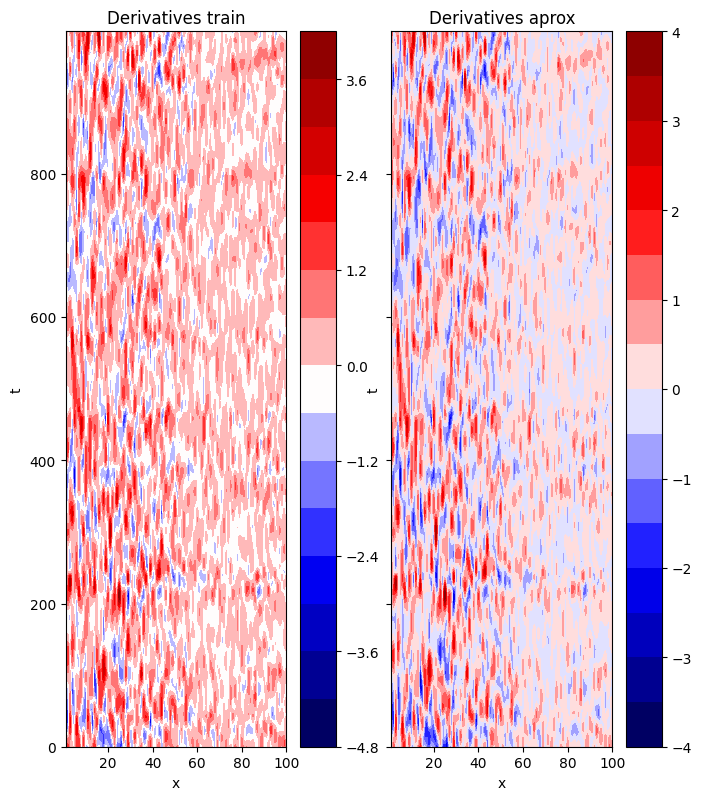

In [ ]:
compare_plot(KS_derivative_data_train[0:1000], KS_op.eval(KS_data_train[0:1000]), "Derivatives train", "Derivatives aprox")

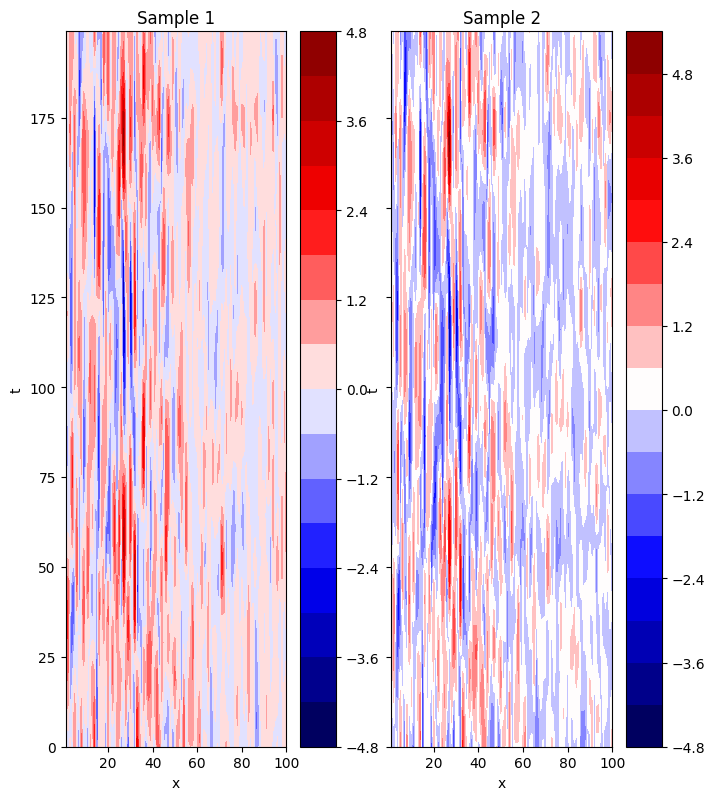

In [ ]:
compare_plot(KS_op.eval(KS_data_test[0:200]),KS_derivative_data_test[0:200])

# Train Dataset

In [ ]:
right_operator = ClassWrapper(KS_op)
solver = LSODA(right_operator)

initial_time = time.time()
estimated_field_train = solver.run(KS_data_train[0], t_data_train[0:1000])
elapsed_time = time.time() - initial_time
print(f"Elapsed time for time-integrating: {elapsed_time} s")

Elapsed time for time-integrating: 1.9412829875946045 s


In [ ]:
# Returning to 512 dimensions

reconstructed_data_train = pipeline.reconstruct_data(data=estimated_field_train)
data_train = pipeline.reconstruct_data(data=KS_data_train)


Applying the global reconstruction strategy.
Applying the global reconstruction strategy.


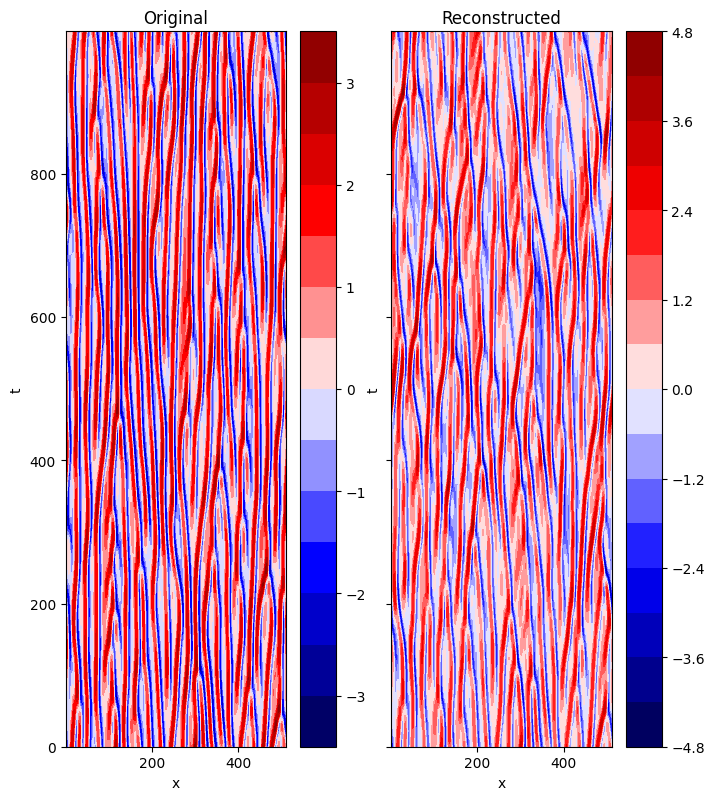

In [ ]:
# Comparing the results

compare_plot(data_train[0:1000], reconstructed_data_train[0:1000],"Original", "Reconstructed")

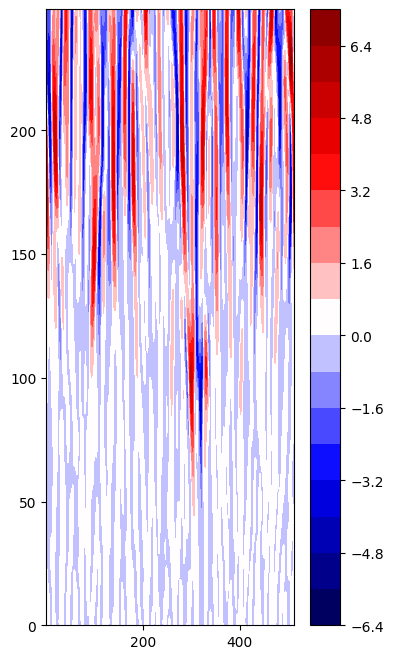

In [ ]:
#plotting the difference between the data

plot(data_train[0:250]-reconstructed_data_train[0:250])

## "View" along time

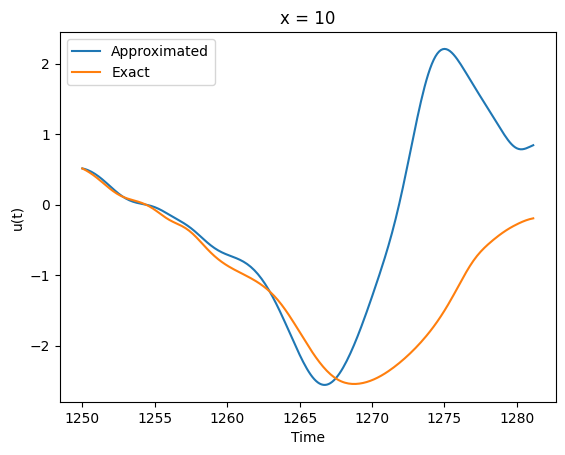

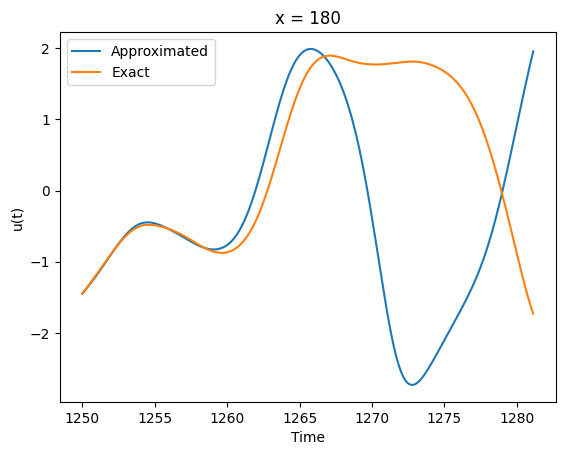

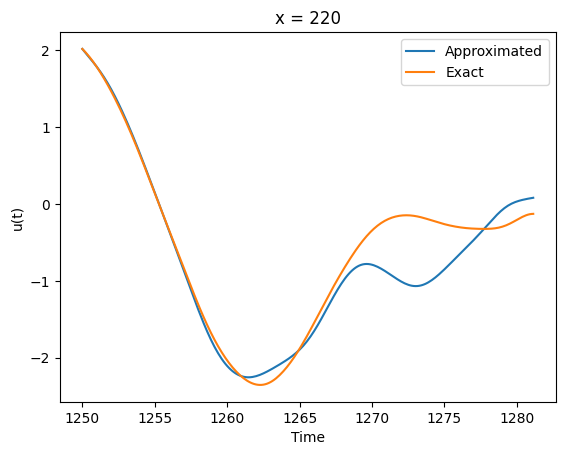

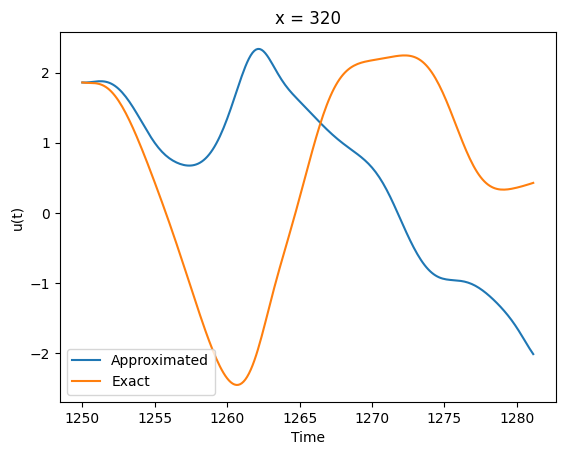

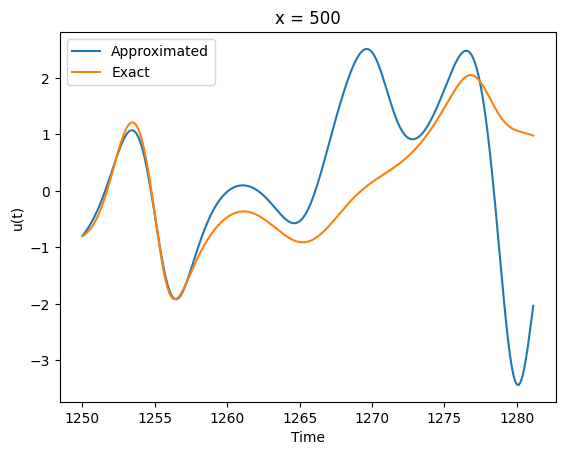

In [ ]:
start = 0
end = 250

samples = [10, 180, 220, 320, 500 ] # x values

for sample in samples:

  time_ref = t_data_train[start:end]
  x = data_train[start:end][:,sample]
  x_aprox = reconstructed_data_train[start:end][:,sample]
  plt.plot(time_ref, x_aprox, label="Approximated")
  plt.plot(time_ref, x, label="Exact")
  plt.xlabel("Time")
  plt.ylabel("u(t)")
  plt.title("x = "+ str(sample))
  plt.legend()
  plt.show()

## "View" along space

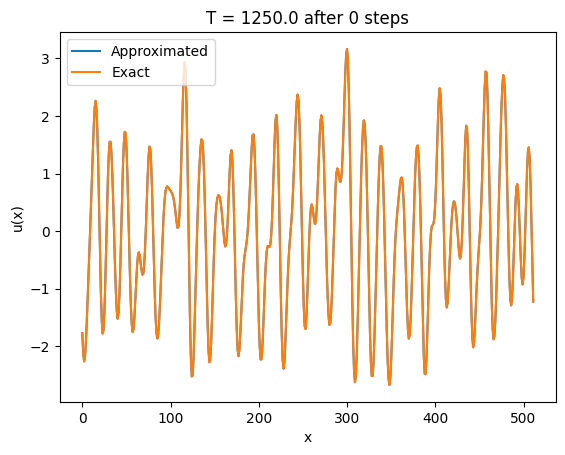

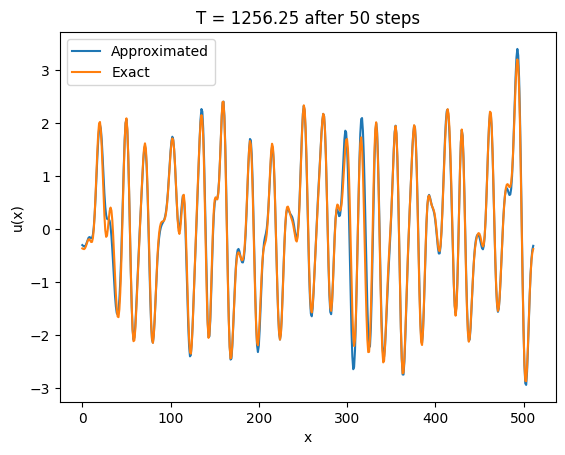

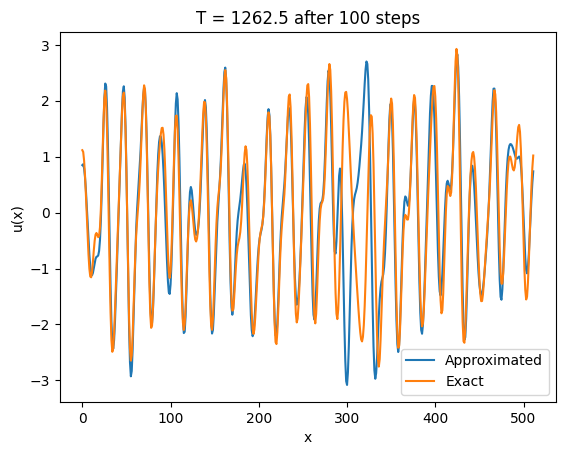

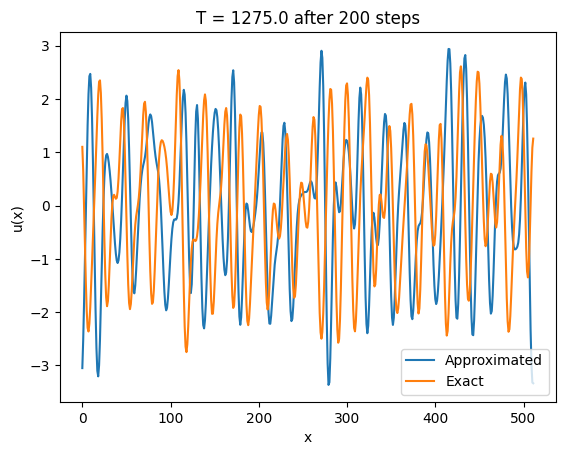

In [ ]:
samples = [0, 50, 100, 200] # t values


for sample in samples:

  x_ref = range(512)
  x = data_train[sample,:]
  x_aprox = reconstructed_data_train[sample,:]

  plt.plot(x_ref, x_aprox, label="Approximated")
  plt.plot(x_ref, x, label="Exact")
  plt.xlabel("x")
  plt.ylabel("u(x)" )
  plt.legend()
  plt.title("T = " + str(t_data_train[sample]) +" after " + str(sample) + " steps"  )
  plt.show()

# Test Dataset

In [ ]:
right_operator = ClassWrapper(KS_op)
solver = LSODA(right_operator)

initial_time = time.time()
estimated_field_test = solver.run(KS_data_train[-1], t_data_test[0:1000])
elapsed_time = time.time() - initial_time
print(f"Elapsed time for time-integrating: {elapsed_time} s")

Elapsed time for time-integrating: 1.189270257949829 s


In [ ]:
# Returning to 512 dimensions

reconstructed_data_test = pipeline.reconstruct_data(data=estimated_field_test)
data_test = pipeline.reconstruct_data(data=KS_data_test)


Applying the global reconstruction strategy.
Applying the global reconstruction strategy.


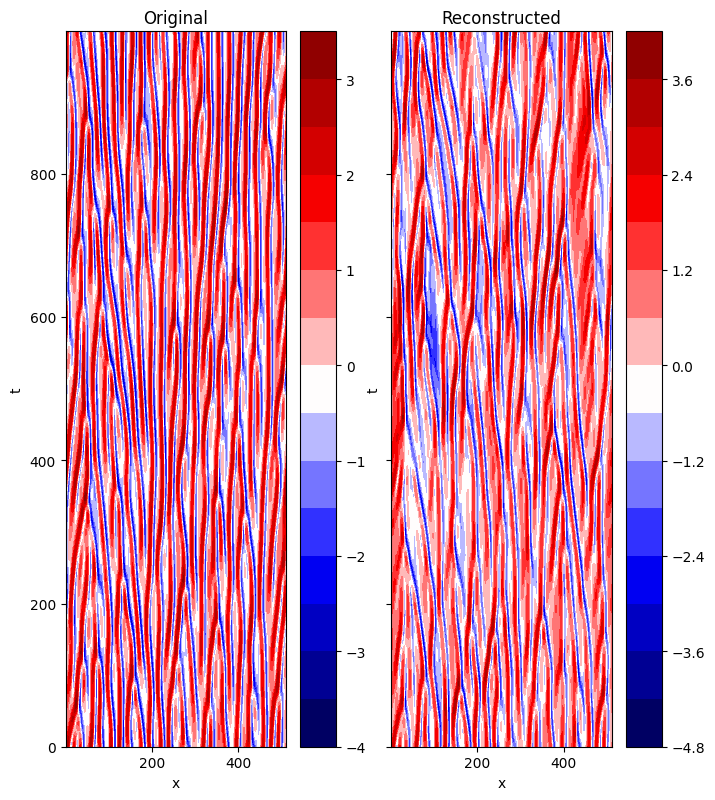

In [ ]:
# Comparing the results

compare_plot(data_test[0:1000], reconstructed_data_test[0:1000],"Original", "Reconstructed")

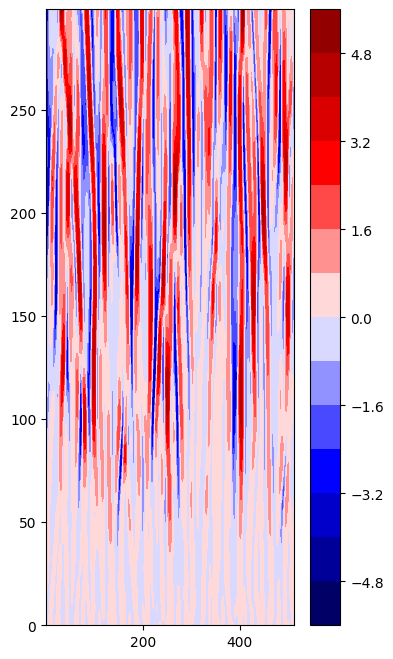

In [ ]:
#plotting the difference between the data

plot(data_test[0:300]-reconstructed_data_test[0:300])

## "View" along time

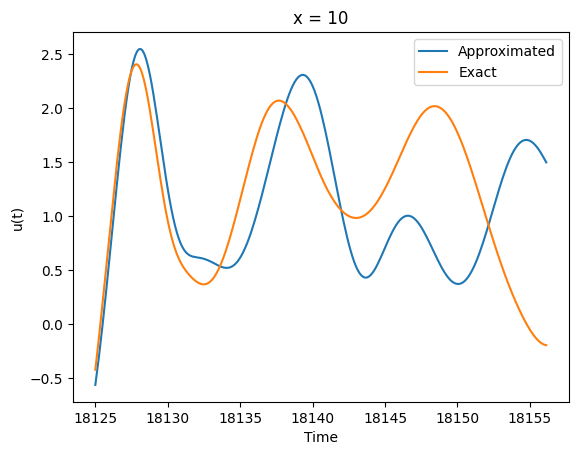

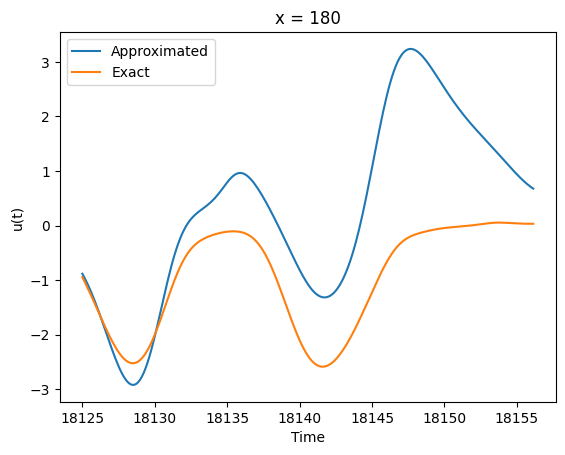

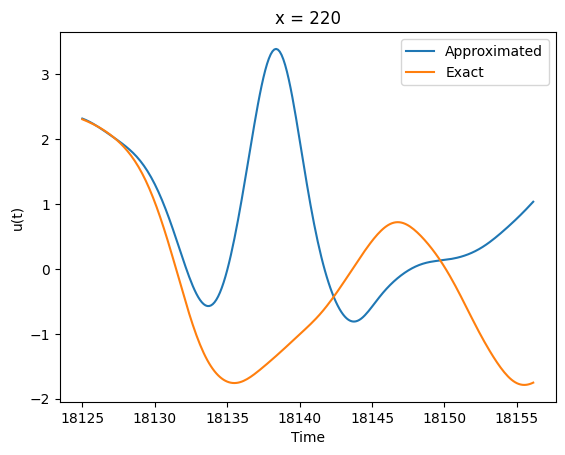

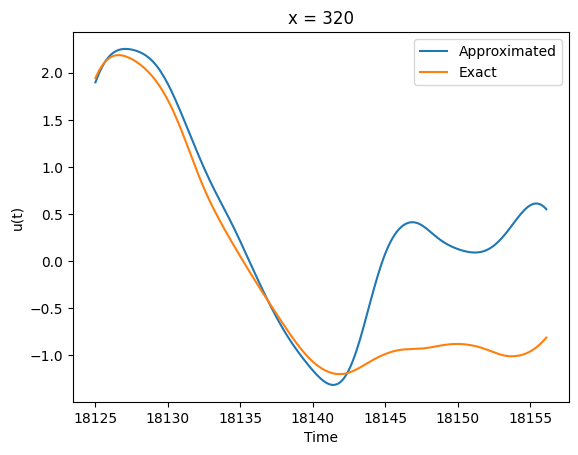

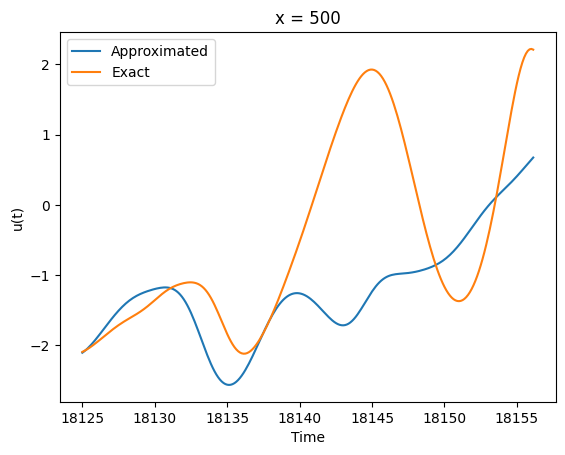

In [ ]:
start = 0
end = 250

samples = [10, 180, 220, 320, 500 ] # x values

for sample in samples:

  time_ref = t_data_test[start:end]
  x = data_test[start:end][:,sample]
  x_aprox = reconstructed_data_test[start:end][:,sample]
  plt.plot(time_ref, x_aprox, label="Approximated")
  plt.plot(time_ref, x, label="Exact")
  plt.xlabel("Time")
  plt.ylabel("u(t)")
  plt.title("x = "+ str(sample))
  plt.legend()
  plt.show()

## "View" along space

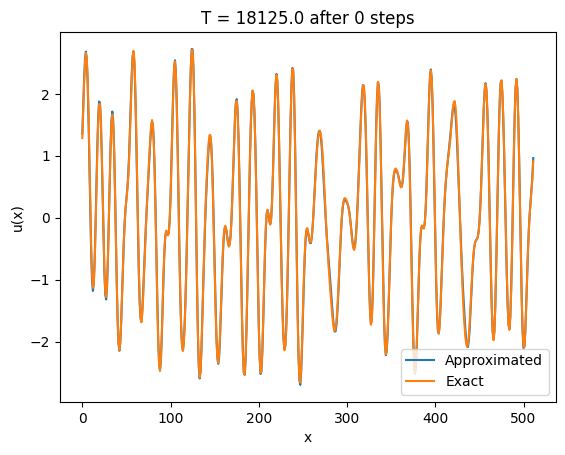

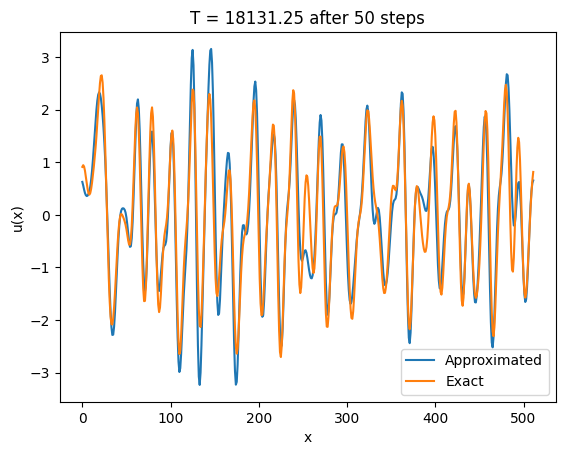

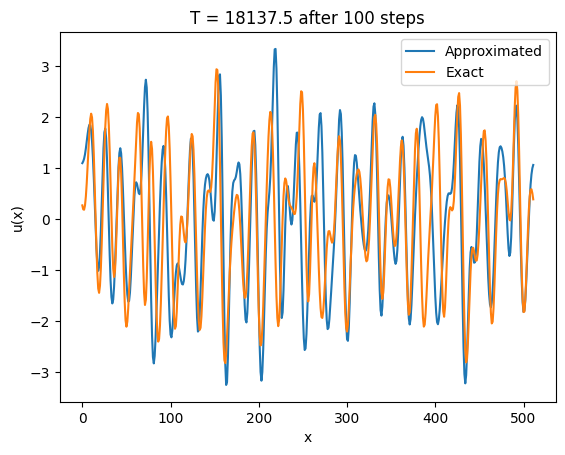

In [ ]:
samples = [0, 50, 100] # t values

for sample in samples:

  x_ref = range(512)
  x = data_test[sample,:]
  x_aprox = reconstructed_data_test[sample,:]

  plt.plot(x_ref, x_aprox, label="Approximated")
  plt.plot(x_ref, x, label="Exact")
  plt.xlabel("x")
  plt.ylabel("u(x)" )
  plt.legend()
  plt.title("T = " + str(t_data_test[sample])+" after " + str(sample) + " steps"  ) 
  plt.show()

# Conclusion

The results of this work for solving the Kuramoto-Sivashinsky problem were obtained by decomposing the initial dataset from 480000, to 150000 samples. Using 90% of the 150000 samples for training, and 10% for testing. The lambdas were chosen by error analysis. Better results can be obtained using the full dataset, which in this case was not used to minimize computational usage.